In [1]:
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from torchtext.data.metrics import bleu_score
from collections import Counter
import unicodedata
import re
import random
import requests
import zipfile

Let's download the dataset, which is an English-French machine translation dataset that I found on the **pytorch** website. After download, I will extract the a text file which contains the English-French sentence pairs.

In [2]:
url = 'https://download.pytorch.org/tutorial/data.zip'
response = requests.get(url)

with open('data.zip', 'wb') as f:
    f.write(response.content)

with zipfile.ZipFile('data.zip', 'r') as archive:
    for file in archive.namelist():
        if file == 'data/eng-fra.txt':
            archive.extract(file, ".")
            break

Extract sentences from target and source language and store them in a list separately.

In [3]:
english_sentences = []
french_sentences = []

with open('./data/eng-fra.txt', 'r', encoding='utf-8') as file:
    for line in file:
        english, french = line.strip().split('\t')
        english_sentences.append(english)
        french_sentences.append(french)

The French language has an accent on some characters, which can make the translation process harder, here we first convert all of the sentences from `utf=8` into `ascii`, this way, the characters with an accent will be replaced by their English counterparts. (`ç` -> `c`)

Next, I will preprocess the sentences with regular expressions to remove punctuations (except "!" and "?"). Also, I will fix the spacing between the words in a way that there is always a space between all the tokens, so when I split them, `!` and `?` don't stick to the other words.

In [4]:
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

eng_cleaned, fr_cleaned = [], []

for eng, fr in zip(english_sentences, french_sentences):
    fr_cl = normalizeString(fr).split()
    eng_cl = normalizeString(eng).split()
    if len(fr_cl) > 5 and len(eng_cl) > 5:
        eng_cleaned.append(eng_cl)
        fr_cleaned.append(fr_cl)

I will use the same custom tokenizer from the previous problem in this assignment, with the difference that it will add start and end of sentence tokens `<SOS>` and `<EOS>` to the sequences. Also, it will not pad the sequences (I will pad them later). The last difference is it can ignore the tokens that are seen less than a specified minimum frequency.

In [5]:
class Tokenizer:
    def __init__(self, texts, min_freq=1):
        self.min_freq = min_freq
        self.vocab = self.build_vocab(texts)
        self.id_to_word = {id: word for word, id in self.vocab.items()}
        self.pad_token_id = 0
        self.unk_token_id = 1
        self.sos_token_id = 2
        self.eos_token_id = 3

    def build_vocab(self, texts):
        # Initialize vocab with special tokens
        vocab = {"<PAD>": 0, "<UNK>": 1, "<SOS>": 2, "<EOS>": 3}
        words = [word for sentence in texts for word in sentence.split()]
        word_counts = Counter(words)

        for word, count in word_counts.items():
            if (self.min_freq <= count) and (word not in vocab):
                vocab[word] = len(vocab)
        return vocab

    def tokenize(self, texts):
        tokenized_texts = []
        for sentence in texts:
            tokens = []
            tokens.append(self.sos_token_id)
            for word in sentence.split():
                token_id = self.vocab.get(word, self.unk_token_id)
                tokens.append(token_id)
            tokens.append(self.eos_token_id)
            tokenized_texts.append(tokens)
        return tokenized_texts

    def decode(self, token_id):
        return self.id_to_word.get(token_id, '<UNK>')

    def vocab_size(self):
        return len(self.vocab)

We can see that incrasing the mean frequency from 1 to 2, can reduce the vocab size of both languages significantly.

In [6]:
print(Tokenizer(english_sentences).vocab_size())
print(Tokenizer(english_sentences, min_freq=2).vocab_size())

25169
15869


In [7]:
print(Tokenizer(french_sentences).vocab_size())
print(Tokenizer(french_sentences, min_freq=2).vocab_size())

41082
23111


There are over 135K English-French pairs, I only take a subset of the whole data due to computational limitations. Then, I will hold out 80% of the subset for training and the rest for test.

In [8]:
assert len(fr_cleaned) == len(eng_cleaned)
combined = list(zip(french_sentences, english_sentences))
random.shuffle(combined)

subset = random.sample(combined, 10000)
fr_subset, eng_subset = zip(*subset)
cut_idx = int(len(fr_subset) * 0.8)
fr_train, fr_val = fr_subset[:cut_idx], fr_subset[cut_idx:]
eng_train, eng_val = eng_subset[:cut_idx], eng_subset[cut_idx:]

Initialize the tokenizers for both languages and splits and tokenize a list of seqences to get a list of token IDs.

In [9]:
eng_tokenizer = Tokenizer(eng_train, min_freq=2)
eng_train_tokenized = eng_tokenizer.tokenize(eng_train)
eng_val_tokenized = eng_tokenizer.tokenize(eng_val)

fr_tokenizer = Tokenizer(fr_train, min_freq=2)
fr_train_tokenized = fr_tokenizer.tokenize(fr_train)
fr_val_tokenized = fr_tokenizer.tokenize(fr_val)

Since I have two lists of token IDs, I will define a simple custom torch dataset which will take two lists of source and target datasets and cobines them together.

In [10]:
class TranslationDataset(Dataset):
    def __init__(self, src_sequences, trg_sequences, pad_idx=0):
        self.src_sequences = src_sequences
        self.trg_sequences = trg_sequences
        self.pad_idx = pad_idx

    def __len__(self):
        return len(self.src_sequences)

    def __getitem__(self, idx):
        src = self.src_sequences[idx]
        src_tensor = torch.tensor(src)
        
        trg = self.trg_sequences[idx]
        trg_tensor = torch.tensor(trg)
        
        return src_tensor, trg_tensor

Since the dataset contains sequences of variable lengths, it's necessary to standardize their lengths for processing. This is essential during batch training, as with different lengths vectorization could not be possible. The most efficient approach is adaptive padding within each batch, where sequences are padded to match the maximum length within the batch, rather than across all data points. To achieve this, I will write a custom collate function for the dataloader.

In [11]:
def collate_fn(batch, pad_idx=0):
    src_batch, trg_batch = zip(*batch)

    src_batch_padded = torch.nn.utils.rnn.pad_sequence(
        src_batch, padding_value=pad_idx, batch_first=False)
    trg_batch_padded = torch.nn.utils.rnn.pad_sequence(
        trg_batch, padding_value=pad_idx, batch_first=False)

    return src_batch_padded, trg_batch_padded

In [12]:
train_dataset = TranslationDataset(
    src_sequences=fr_train_tokenized, trg_sequences=eng_train_tokenized)

dataloader = DataLoader(train_dataset, batch_size=16,
                        collate_fn=collate_fn, shuffle=False)

### Vanilla Seq2Seq LSTM

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_size, embed_dim, hidden_size, dropout_prob=0.5):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, embed_dim)
        self.droupout = nn.Dropout(dropout_prob)

        self.recurrent = nn.LSTM(embed_dim, hidden_size)

    def forward(self, x):
        # x = (seq_len, bs)
        embedded = self.droupout(self.embedding(x))  # (seq_len, bs, embed_dim)

        # output size -> (seq_len, bs, h)
        # hidden size -> (1, bs, h)
        outputs, (hidden, cell) = self.recurrent(embedded)
        return hidden, cell

In [14]:
class Decoder(nn.Module):
    def __init__(self, input_size, output_size, embed_dim, hidden_size, dropout_prob=0.5):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding = nn.Embedding(input_size, embed_dim)
        self.droupout = nn.Dropout(dropout_prob)

        self.recurrent = nn.LSTM(embed_dim, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell):
        # x = (bs, )
        # (1, bs) because we are generating one token at a time
        x = x.unsqueeze(0)
        embedded = self.droupout(self.embedding(x))
        outputs, (hidden, cell) = self.recurrent(
            embedded, (hidden, cell))  # (1, bs, h)

        # (1, bs, output_size) - > (bs, output_size)
        preds = self.fc(outputs).squeeze(0)

        return preds, hidden, cell

In [15]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.to(device)

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        batch_size = source.shape[1]  # source shape: (seq_len, bs)
        target_max_len = target.shape[0]  # target shape: (seq_len, bs)

        outputs = torch.zeros(target_max_len, batch_size,
                              self.decoder.output_size).to(self.device)

        hidden, cell = self.encoder(source)

        x = target[0]  # <SOS> token

        for i in range(1, target_max_len):
            output, hidden, cell = self.decoder(x, hidden, cell)
            outputs[i] = output
            pred = output.argmax(1)
            if random.random() < teacher_forcing_ratio:
                x = target[i]
            else:
                x = pred
        return outputs

In [16]:
def train_model(model, dataloader, criterion, optimizer, num_epochs):
    model.train()
    epoch_losses = []

    for epoch in range(num_epochs):
        epoch_loss = 0.0

        for batch in dataloader:
            inp_data = batch[0].to(model.device)
            target = batch[1].to(model.device)

            output = model(inp_data, target)

            # Output shape (target_len, batch_size, vocab_size)
            # Cross Entropy Loss takes (batch_size, dim)
            # Reshape and merge first two dimensions
            output = output[1:].reshape(-1, output.shape[2])
            target = target[1:].reshape(-1)

            optimizer.zero_grad()
            loss = criterion(output, target)

            loss.backward()

            # clip gradients to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

            optimizer.step()

            epoch_loss += loss.item()

        epoch_loss /= len(dataloader)
        epoch_losses.append(epoch_loss)
        print(f"Epoch {epoch + 1} / {num_epochs},\tLoss: {epoch_loss}")

    return epoch_losses

In [17]:
def plot_losses(losses, text='Training Loss'):
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(text)
    plt.show()

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size_encoder = fr_tokenizer.vocab_size()
input_size_decoder = eng_tokenizer.vocab_size()
output_size = input_size_decoder
encoder_embed_dim = 100
decoder_embed_dim = 100
hidden_size = 128
num_layers = 1
enc_dropout = 0.5
dec_dropout = 0.5

encoder_net = Encoder(
    input_size_encoder, encoder_embed_dim, hidden_size, enc_dropout
).to(device)

decoder_net = Decoder(
    input_size_decoder,
    output_size,
    decoder_embed_dim,
    hidden_size,
    dec_dropout,
).to(device)

model = Seq2Seq(encoder_net, decoder_net, device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss(ignore_index=eng_tokenizer.pad_token_id)

seq2seq_hist = train_model(
    model, dataloader, criterion, optimizer, num_epochs=20)

Epoch 1 / 20,	Loss: 5.2438866176605226
Epoch 2 / 20,	Loss: 4.783759317398071
Epoch 3 / 20,	Loss: 4.60143411397934
Epoch 4 / 20,	Loss: 4.4783236637115476
Epoch 5 / 20,	Loss: 4.396715697765351
Epoch 6 / 20,	Loss: 4.331713377475738
Epoch 7 / 20,	Loss: 4.25587202835083
Epoch 8 / 20,	Loss: 4.191513620376587
Epoch 9 / 20,	Loss: 4.145000604629517
Epoch 10 / 20,	Loss: 4.08994025182724
Epoch 11 / 20,	Loss: 4.064297110080719
Epoch 12 / 20,	Loss: 4.028329260826111
Epoch 13 / 20,	Loss: 3.991602994918823
Epoch 14 / 20,	Loss: 3.975645444869995
Epoch 15 / 20,	Loss: 3.9088865699768065
Epoch 16 / 20,	Loss: 3.878532799720764
Epoch 17 / 20,	Loss: 3.858338650226593
Epoch 18 / 20,	Loss: 3.8547569584846495
Epoch 19 / 20,	Loss: 3.8037332291603088
Epoch 20 / 20,	Loss: 3.797085060596466


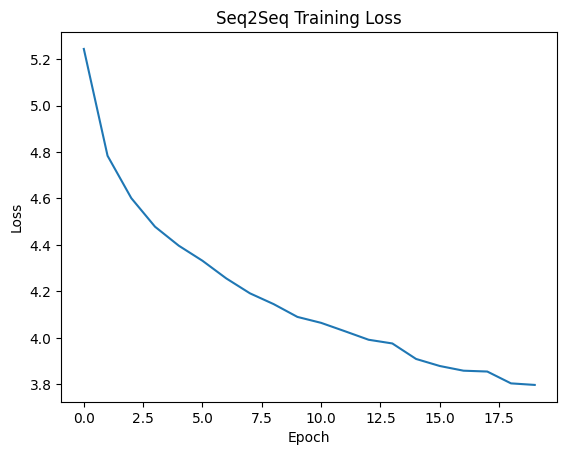

In [19]:
plot_losses(seq2seq_hist, text='Seq2Seq Training Loss')

### Attention Seq2Seq LSTM

In [20]:
class EncoderAttn(nn.Module):
    def __init__(self, input_size, embed_dim, hidden_size, dropout_prob=0.5):
        super(EncoderAttn, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, embed_dim)
        self.droupout = nn.Dropout(dropout_prob)

        self.recurrent = nn.LSTM(embed_dim, hidden_size, bidirectional=True)
        self.fc_hidden = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_cell = nn.Linear(hidden_size * 2, hidden_size)

    def forward(self, x):
        # x = (seq_len, batch_size)
        # (seq_len, bs, embed_dim)
        embedded = self.droupout(self.embedding(x))

        # hidden.shape -> (num_directions, bs, h)
        outputs, (hidden, cell) = self.recurrent(embedded)
        # outputs.shape: (seq_len, bs, h * num_directions)

        hidden = torch.tanh(self.fc_hidden(
            torch.cat((hidden[0, :, :], hidden[1, :, :]), dim=1))).unsqueeze(0)  # (1, bs, h)
        cell = torch.tanh(self.fc_cell(
            torch.cat((cell[0, :, :], cell[1, :, :]), dim=1))).unsqueeze(0)  # (1, bs, h)
        return outputs, hidden, cell

In [21]:
class DecoderAttn(nn.Module):
    def __init__(self, input_size, output_size, embed_dim, hidden_size, dropout_prob=0.5):
        super(DecoderAttn, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding = nn.Embedding(input_size, embed_dim)
        self.droupout = nn.Dropout(dropout_prob)

        self.recurrent = nn.LSTM(embed_dim + 2 * hidden_size, hidden_size)
        self.energy = nn.Linear(hidden_size * 3, 1)
        self.softmax = nn.Softmax(dim=0)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, encoder_out, hidden, cell):
        # x = (bs, )
        # (1, bs) because we are generating one token at a time
        x = x.unsqueeze(0)
        embedded = self.droupout(self.embedding(x))  # (1, bs, embed_dim)

        seq_length = encoder_out.shape[0]
        h_reshaped = hidden.repeat(seq_length, 1, 1)  # (seq_len, bs, h)

        # enc_outputs shape -> (seq_len, bs, 2h)
        h_cat = torch.cat((h_reshaped, encoder_out),
                          dim=-1)  # (seq_len, bs, 3h)

        # We approximate eij mentioned in https://arxiv.org/pdf/1409.0473.pdf with a neural network
        # energy shape: (seq_len, bs, 1)
        energy = self.relu(self.energy(h_cat))
        attention = self.softmax(energy)  # attention shape: (seq_len, bs, 1)

        attention = attention.permute(1, 2, 0)  # (bs, 1, seq_len)
        # encoder_out.shape: (seq_len, bs, 2h)
        encoder_out = encoder_out.permute(1, 0, 2)  # (bs, seq_len, 2h)

        context_vector = torch.bmm(attention, encoder_out)  # (bs, 1, 2h)
        context_vector = context_vector.permute(1, 0, 2)  # (1, bs, 2h)

        # (1, bs, 2h + embed_dim)
        recurrent_input = torch.cat((context_vector, embedded), dim=-1)
        outputs, (hidden, cell) = self.recurrent(recurrent_input,
                                                 (hidden, cell))  # outputs.shape: (1, bs, h)

        # (1, bs, output_size) - > (bs, output_size)
        preds = self.fc(outputs).squeeze(0)

        return preds, hidden, cell

In [22]:
class Seq2SeqAttn(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2SeqAttn, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.to(device)

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        batch_size = source.shape[1]  # source shape: (seq_len, batch_size)
        target_max_len = target.shape[0]  # target shape: (seq_len, batch_size)

        outputs = torch.zeros(target_max_len, batch_size,
                              self.decoder.output_size).to(self.device)

        encoder_out, hidden, cell = self.encoder(source)

        x = target[0]  # <SOS> token

        for i in range(1, target_max_len):
            output, hidden, cell = self.decoder(x, encoder_out, hidden, cell)
            outputs[i] = output
            pred = output.argmax(1)
            if random.random() < teacher_forcing_ratio:
                x = target[i]
            else:
                x = pred
        return outputs

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size_encoder = fr_tokenizer.vocab_size()
input_size_decoder = eng_tokenizer.vocab_size()
output_size = input_size_decoder
encoder_embed_dim = 128
decoder_embed_dim = 128
hidden_size = 128
enc_dropout = 0.5
dec_dropout = 0.5

attention_encoder = EncoderAttn(
    input_size_encoder,
    encoder_embed_dim,
    hidden_size,
    enc_dropout
).to(device)

attention_decoder = DecoderAttn(
    input_size_decoder,
    output_size,
    decoder_embed_dim,
    hidden_size,
    dec_dropout,
).to(device)

attention_model = Seq2SeqAttn(attention_encoder, attention_decoder, device)
optimizer = optim.Adam(attention_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss(ignore_index=eng_tokenizer.pad_token_id)

attention_hist = train_model(
    attention_model, dataloader, criterion, optimizer, num_epochs=30)

Epoch 1 / 30,	Loss: 5.33203507900238
Epoch 2 / 30,	Loss: 4.9678156309127806
Epoch 3 / 30,	Loss: 4.883312818527222
Epoch 4 / 30,	Loss: 4.705601308822632
Epoch 5 / 30,	Loss: 4.5911375765800475
Epoch 6 / 30,	Loss: 4.486495908737183
Epoch 7 / 30,	Loss: 4.405535309314728
Epoch 8 / 30,	Loss: 4.351211771011353
Epoch 9 / 30,	Loss: 4.308403910636902
Epoch 10 / 30,	Loss: 4.280982666015625
Epoch 11 / 30,	Loss: 4.24788686800003
Epoch 12 / 30,	Loss: 4.214169496059418
Epoch 13 / 30,	Loss: 4.191403348922729
Epoch 14 / 30,	Loss: 4.1508645849227905
Epoch 15 / 30,	Loss: 4.134031547546387
Epoch 16 / 30,	Loss: 4.1039152135849
Epoch 17 / 30,	Loss: 4.096928220748901
Epoch 18 / 30,	Loss: 4.089681008338928
Epoch 19 / 30,	Loss: 4.057227909564972
Epoch 20 / 30,	Loss: 4.034491000175476
Epoch 21 / 30,	Loss: 4.021757281780243
Epoch 22 / 30,	Loss: 4.026958724975586
Epoch 23 / 30,	Loss: 4.0116348891258236
Epoch 24 / 30,	Loss: 3.9949269800186156
Epoch 25 / 30,	Loss: 3.9898952836990356
Epoch 26 / 30,	Loss: 3.969290970

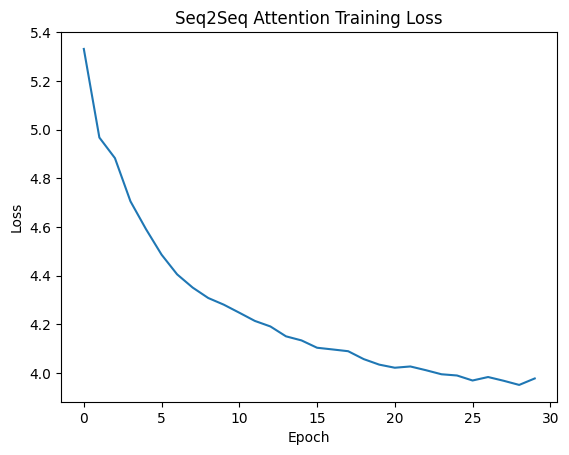

In [24]:
plot_losses(attention_hist, text='Seq2Seq Attention Training Loss')

In [25]:
def translate_sentence(model, sentence, src_tokenizer, dst_tokenizer, device, max_length=50):
    model.eval()
    if isinstance(sentence, str):
        tokenized_list = src_tokenizer.tokenize([sentence])[0]
    else:
        tokenized_list = sentence

    sentence_tensor = torch.LongTensor(tokenized_list).unsqueeze(1).to(device)

    with torch.no_grad():
        enc_out = model.encoder(sentence_tensor)

    if len(enc_out) == 3:
        outputs_encoder, hiddens, cells = enc_out
    else:
        hiddens, cells = enc_out
        
    outputs = [dst_tokenizer.sos_token_id]

    for _ in range(max_length):
        previous_word = torch.LongTensor([outputs[-1]]).to(device)

        with torch.no_grad():
            if len(enc_out) == 3:
                output, hiddens, cells = model.decoder(
                    previous_word, outputs_encoder, hiddens, cells
                )
            else:
                output, hiddens, cells = model.decoder(
                    previous_word, hiddens, cells
                )

            prediction = output.argmax(1).item()

        outputs.append(prediction)

        if output.argmax(1).item() == dst_tokenizer.eos_token_id:
            break

    outputs = outputs[:-
                      1] if outputs[-1] == dst_tokenizer.eos_token_id else outputs

    translated_sentence = [dst_tokenizer.decode(idx) for idx in outputs]

    return translated_sentence[1:]

In [26]:
def calc_bleu_score(model, src_data, dest_data, src_tokenizer, dst_tokenizer, device='cuda'):
    candidate = [translate_sentence(
        model, sentence, src_tokenizer, dst_tokenizer, device) for sentence in src_data]
    references = [[sentence.split()] for sentence in dest_data]
    return bleu_score(candidate, references)

In [27]:
calc_bleu_score(model, fr_val, eng_val,
                fr_tokenizer, eng_tokenizer)

0.012378146077334314

In [28]:
calc_bleu_score(attention_model, fr_val, eng_val,
                fr_tokenizer, eng_tokenizer)

0.01229545584900723

In [29]:
calc_bleu_score(model, fr_train, eng_train,
                fr_tokenizer, eng_tokenizer)

0.011283614202402929

In [30]:
calc_bleu_score(attention_model, fr_train, eng_train,
                fr_tokenizer, eng_tokenizer)

0.012857445050137016

In [75]:
A = "je suis tom"

print(translate_sentence(model, A,
                         fr_tokenizer, eng_tokenizer, device))

print(translate_sentence(attention_model, A,
                         fr_tokenizer, eng_tokenizer, device))

['<UNK>', '<UNK>']
['I', 'thought', 'you', 'to']


After training both models, it is evident that while the `attention_model` was trained for an additional 10 iterations, its loss decreased by less than the vanilla seq2seq model. This indicates that training the attention model for more iterations is necessary, as it has a higher number of parameters (42% higher) with the same hyperparameters. Based on the Bleu score, both models perform similarly, with the vanilla model even performing slightly better. This shows that simply adding attention is not sufficient to improve performance. The attention model require more training data and itearions and performs better on longer sequences. For this assignment, due to computational limitations, the models were only trained for a small number of iterations to present them as a proof of concept. For a more extensive comparison, both models should be trained on a larger dataset and for more iterations.

In [76]:
model_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in vanila seq2seq: {model_params}")

attention_params = sum(p.numel() for p in attention_model.parameters())
print(f"Total number of parameters in vanila seq2seq: {attention_params}")

Total number of parameters in vanila seq2seq: 1257486
Total number of parameters in vanila seq2seq: 1794955
